In [91]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from mlmicrophysics.models import DenseNeuralNetwork
from sklearn.ensemble import RandomForestClassifier
from mlmicrophysics.explain import partial_dependence_2d
from mlmicrophysics.data import subset_data_files_by_date, log10_transform, neg_log10_transform, assemble_data_files
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import r2_score, confusion_matrix, mean_squared_error
from keras.models import save_model
from keras.layers import Input, Dense, Dropout, GaussianNoise, Activation, Concatenate, BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam, SGD
import keras.backend as K
import yaml
from matplotlib.colors import LogNorm
scalers = {"MinMaxScaler": MinMaxScaler,
           "MaxAbsScaler": MaxAbsScaler,
           "StandardScaler": StandardScaler,
           "RobustScaler": RobustScaler}
transforms = {"log10_transform": log10_transform,
              "neg_log10_transform": neg_log10_transform}
import call_collect

In [2]:
ls /glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/

cam_mp_data_run2_000000.csv     cam_mp_data_run2_qc_008856.csv
cam_mp_data_run2_000123.csv     cam_mp_data_run2_qc_008979.csv
cam_mp_data_run2_000246.csv     cam_mp_data_run2_qc_009102.csv
cam_mp_data_run2_000369.csv     cam_mp_data_run2_qc_009225.csv
cam_mp_data_run2_000492.csv     cam_mp_data_run2_qc_009348.csv
cam_mp_data_run2_000615.csv     cam_mp_data_run2_qc_009471.csv
cam_mp_data_run2_000738.csv     cam_mp_data_run2_qc_009594.csv
cam_mp_data_run2_000861.csv     cam_mp_data_run2_qc_009717.csv
cam_mp_data_run2_000984.csv     cam_mp_data_run2_qc_009840.csv
cam_mp_data_run2_001107.csv     cam_mp_data_run2_qc_009963.csv
cam_mp_data_run2_001230.csv     cam_mp_data_run2_qc_010086.csv
cam_mp_data_run2_001353.csv     cam_mp_data_run2_qc_010209.csv
cam_mp_data_run2_001476.csv     cam_mp_data_run2_qc_010332.csv
cam_mp_data_run2_001599.csv     cam_mp_data_run2_qc_010455.csv
cam_mp_data_run2_001722.csv     cam_mp_data_run2_qc_010578.csv
cam_mp_data_run2_001845.csv     cam_mp_data_run2_qc_010

# Data Loading

In [3]:
path = "/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/"
#path = "/Users/dgagne/data/cam_mp_files_run2_csv/"
train_files, val_files, test_files = subset_data_files_by_date(path, "_qc_*.csv", train_date_start=0, train_date_end=8000, 
                                                               test_date_start=8100, test_date_end=16000)

[    0   123   246   369   492   615   738   861   984  1107  1230  1353
  1476  1599  1722  1845  1968  2091  2214  2337  2460  2583  2706  2829
  2952  3075  3198  3321  3444  3567  3690  3813  3936  4059  4182  4305
  4428  4551  4674  4797  4920  5043  5166  5289  5412  5535  5658  5781
  5904  6027  6150  6273  6396  6519  6642  6765  6888  7011  7134  7257
  7380  7503  7626  7749  7872  7995  8118  8241  8364  8487  8610  8733
  8856  8979  9102  9225  9348  9471  9594  9717  9840  9963 10086 10209
 10332 10455 10578 10701 10824 10947 11070 11193 11316 11439 11562 11685
 11808 11931 12054 12177 12300 12423 12546 12669 12792 12915 13038 13161
 13284 13407 13530 13653 13776 13899 14022 14145 14268 14391 14514 14637
 14760 14883 15006 15129 15252 15375 15498 15621 15744 15867 15990 16113
 16236 16359 16482 16605 16728 16851 16974 17097 17220 17343 17466]


In [4]:
input_transforms_yaml = """
  RHO_CLUBB_lev: log10_transform
  QC_TAU_in: log10_transform
  NC_TAU_in: log10_transform
  QR_TAU_in: log10_transform
  NR_TAU_in: log10_transform
  """
output_transforms_yaml = """
  qctend_TAU:
    0: [">=", -1e-15, "zero_transform", "None"]
    1: ["<", -1e-15, "neg_log10_transform", "StandardScaler"]
  qrtend_TAU:
    0: ["<=", 1e-15, "zero_transform", "None"]
    1: [">", 1e-15, "log10_transform", "StandardScaler"]
  nctend_TAU:
    0: [">=", -1e-15, "zero_transform", "None"]
    1: ["<", -1e-15, "neg_log10_transform", "StandardScaler"]
  nrtend_TAU:
    -1: ["<", 0, "neg_log10_transform", "StandardScaler"]
    0: ["==", 0, "zero_transform", "None"]
    1: [">", 0, "log10_transform", "StandardScaler"]
  qctend_MG2:
    0: [">=", -1e-15, "zero_transform", "None"]
    1: ["<", -1e-15, "neg_log10_transform", "StandardScaler"]
  qrtend_MG2:
    0: ["<=", 1e-15, "zero_transform", "None"]
    1: [">", 1e-15, "log10_transform", "StandardScaler"]
  nctend_MG2:
    0: [">=", -1e-15, "zero_transform", "None"]
    1: ["<", -1e-15, "neg_log10_transform", "StandardScaler"]
  nrtend_MG2:
    -1: ["<", 0, "neg_log10_transform", "StandardScaler"]
    0: ["==", 0, "zero_transform", "None"]
    1: [">", 0, "log10_transform", "StandardScaler"]
"""
input_transforms = yaml.load(input_transforms_yaml)
output_transforms = yaml.load(output_transforms_yaml)

In [4]:
input_transforms

{'temperature': 'log10_transform',
 'RHO_CLUBB_lev': 'log10_transform',
 'QC_TAU_in': 'log10_transform',
 'NC_TAU_in': 'log10_transform',
 'QR_TAU_in': 'log10_transform',
 'NR_TAU_in': 'log10_transform'}

In [5]:
input_scaler = StandardScaler()
input_cols = ["QC_TAU_in", "QR_TAU_in", "NC_TAU_in", "NR_TAU_in", "RHO_CLUBB_lev"]
output_cols = ["qctend_TAU", "qrtend_TAU", "nctend_TAU", "nrtend_TAU", 
               "qctend_MG2", "qrtend_MG2", "nctend_MG2", "nrtend_MG2"]

scaled_input_train,\
    labels_train,\
    transformed_out_train,\
    scaled_out_train,\
    output_scalers =  assemble_data_files(train_files, input_cols, output_cols, input_transforms,
                                          output_transforms, input_scaler, subsample=1)

/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_000123.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_000246.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_000492.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_000615.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_000861.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_000984.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_001230.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_001353.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_001599.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_001722.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_001968.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_002091.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_

In [107]:
input_scaler_df = pd.DataFrame({"mean":input_scaler.mean_, "scale": input_scaler.scale_},
                               index=input_cols)
input_scaler_df.to_csv("/glade/p/cisl/aiml/dgagne/cam_run2_models/input_scale_values.csv",
                       index_label="input")
input_scaler_df


,mean,scale
QC_TAU_in,-5.430308,1.657129
QR_TAU_in,-8.438085,2.403416
NC_TAU_in,5.712348,1.717281
NR_TAU_in,0.650230,2.650545
RHO_CLUBB_lev,0.025618,0.081442


In [115]:
out_scales_list = []
for var in output_scalers.keys():
    for out_class in output_scalers[var].keys():
        print(var, out_class)
        if output_scalers[var][out_class] is not None:
            out_scales_list.append(pd.DataFrame({"mean": output_scalers[var][out_class].mean_,
                                         "scale": output_scalers[var][out_class].scale_},
                                        index=[var + "_" + str(out_class)]))
out_scales_df = pd.concat(out_scales_list)
print(out_scales_df)
out_scales_df.to_csv("/glade/p/cisl/aiml/dgagne/cam_run2_models/output_scale_values.csv",
                     index_label="output")

qctend_TAU 0
qctend_TAU 1
qrtend_TAU 0
qrtend_TAU 1
nctend_TAU 0
nctend_TAU 1
nrtend_TAU -1
nrtend_TAU 0
nrtend_TAU 1
qctend_MG2 0
qctend_MG2 1
qrtend_MG2 0
qrtend_MG2 1
nctend_MG2 0
nctend_MG2 1
nrtend_MG2 -1
nrtend_MG2 0
nrtend_MG2 1
                    mean     scale
qctend_TAU_1  -10.701557  1.735827
qrtend_TAU_1  -10.701557  1.735827
nctend_TAU_1    0.557118  2.498400
nrtend_TAU_-1  -4.549045  2.500659
nrtend_TAU_1   -2.086539  1.583013
qctend_MG2_1  -10.156511  1.580637
qrtend_MG2_1  -10.156511  1.580637
nctend_MG2_1    0.001220  3.238188
nrtend_MG2_-1  -1.569837  2.740709
nrtend_MG2_1    0.173304  1.791257


In [20]:
labels_train["nctend_TAU"].max()

1

In [6]:
scaled_input_test,\
    labels_test,\
    transformed_out_test,\
    scaled_out_test,\
    output_scalers_test = assemble_data_files(test_files, input_cols, output_cols, input_transforms,
                                             output_transforms, input_scaler, output_scalers=output_scalers,
                                             subsample=0.1)

/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_008118.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_008241.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_008364.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_008487.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_008610.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_008733.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_008856.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_008979.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_009102.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_009225.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_009348.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_qc_009471.csv
/glade/p/cisl/aiml/dgagne/cam_mp_files_run2_csv/cam_

In [11]:
np.count_nonzero(labels_train["nctend_TAU"] == 0)

524790

In [85]:
original_input_train = pd.DataFrame(10 ** input_scaler.inverse_transform(scaled_input_train), 
                                    columns=scaled_input_train.columns)


In [12]:
np.sum(labels_train["nrtend_TAU"] ==-1)

11837

In [82]:
pd_bins = 20

pd_vals = np.zeros((len(input_cols), pd_bins))

for v, var in enumerate(input_cols):
    pd_vals[v] = np.logspace(np.log10(original_input_train[var].min()), np.log10(original_input_train[var].max()), pd_bins)


In [93]:
pd_bins = 20
pd_vals = np.zeros((len(input_cols), pd_bins))
pd_grid_tau = np.zeros((len(input_cols), pd_bins, 5))
for v, var in enumerate(input_cols):
    print(var)
    pd_vals[v] = np.logspace(np.log10(original_input_train[var].min()), np.log10(original_input_train[var].max()), pd_bins)
    train_copy = original_input_train.loc[labels_train["qctend_TAU"] == 1].copy()
    for p, pd_val in enumerate(pd_vals[v]):
        print(p, pd_val)
        train_copy.loc[:, var] = pd_val
        out_vals = np.array(call_collect.call_collect(1800.0, 
                                                      np.ones(train_copy.shape[0]) * 12,
                          train_copy["RHO_CLUBB_lev"].values,
                          train_copy["QC_TAU_in"].values,
                          train_copy["NC_TAU_in"].values,
                          train_copy["QR_TAU_in"].values,
                          train_copy["NR_TAU_in"].values))
        out_vals[0][out_vals[0] > -1e-15] = 0
        print(out_vals.shape)
        pd_grid_tau[v, p, 0] = np.log10(-out_vals[0][out_vals[0] < 0]).mean()
        pd_grid_tau[v, p, 1] = np.log10(-out_vals[1][out_vals[1] < 0]).mean()
        pd_grid_tau[v, p, 2] = np.log10(out_vals[2][out_vals[2] > 0]).mean()
        pd_grid_tau[v, p, 3] = np.log10(out_vals[3][out_vals[3] > 0]).mean()
        pd_grid_tau[v, p, 4] = np.log10(-out_vals[3][out_vals[3]< 0]).mean()
        

QC_TAU_in
0 9.90343242971231e-13


KeyboardInterrupt: 

In [69]:
out_var_names = ["QC", "NC", "QR", "NR"]
for o, out_var_name in enumerate(out_var_names):
    fig, axes = plt.subplots(3, 2, figsize=(6, 9))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    for a, ax in enumerate(axes.ravel()):
        ax.plot(np.log10(pd_vals[a]), pd_grid_tau[a, :, o], '-')
        ax.set_xlabel(input_cols[a].replace("_", " "))
    fig.suptitle(f"TAU Microphysics Partial Dependence {out_var_name}", fontsize=14, y=0.93)
    plt.savefig(f"tau_partial_dependence_{out_var_name.lower()}.png", bbox_inches="tight", dpi=200)
    plt.close()

In [7]:
print(call_collect.call_collect.__doc__)

qctend_tau,nctend_tau,qrtend_tau,nrtend_tau = collect_step(deltatin,t,rho,qcin,ncin,qrin,nrin,[mgncol])

Wrapper for ``collect_step``.

Parameters
----------
deltatin : input float
t : input rank-1 array('d') with bounds (mgncol)
rho : input rank-1 array('d') with bounds (mgncol)
qcin : input rank-1 array('d') with bounds (mgncol)
ncin : input rank-1 array('d') with bounds (mgncol)
qrin : input rank-1 array('d') with bounds (mgncol)
nrin : input rank-1 array('d') with bounds (mgncol)

Other Parameters
----------------
mgncol : in/output rank-0 array(int,'i'), optional
    Default: len(t)

Returns
-------
qctend_tau : rank-1 array('d') with bounds (mgncol)
nctend_tau : rank-1 array('d') with bounds (mgncol)
qrtend_tau : rank-1 array('d') with bounds (mgncol)
nrtend_tau : rank-1 array('d') with bounds (mgncol)



In [16]:
qctend_tau, nctend_tau, qrtend_tau, nrtend_tau = call_collect.call_collect(1800.0, 
                          original_input_train["temperature"].values, 
                          original_input_train["RHO_CLUBB_lev"].values,
                          original_input_train["QC_TAU_in"].values,
                          original_input_train["NC_TAU_in"].values,
                          original_input_train["QR_TAU_in"].values,
                          original_input_train["NR_TAU_in"].values)

In [65]:
qctend_tau_top, nctend_tau_top, qrtend_tau_top, nrtend_tau_top = call_collect.call_collect(1800.0, 
                          original_input_train["temperature"].values, 
                          original_input_train["RHO_CLUBB_top"].values,
                          original_input_train["QC_TAU_in"].values,
                          original_input_train["NC_TAU_in"].values,
                          original_input_train["QR_TAU_in"].values,
                          original_input_train["NR_TAU_in"].values)

In [26]:
np.count_nonzero(qctend_tau > 0)

10203

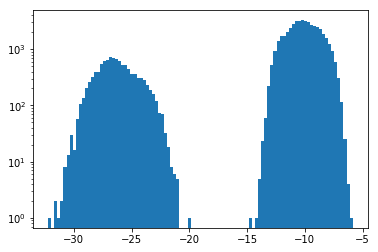

In [45]:
plt.hist(np.log10(-qctend_tau[qctend_tau < 0]), bins=100)
plt.gca().set_yscale("log")

(array([  1.,   0.,   1.,   3.,   1.,   5.,   7.,  17.,  18.,  34.,  58.,
         68.,  98., 138., 221., 240., 406., 490., 580., 706., 778., 782.,
        874., 829., 583., 539., 489., 470., 419., 414., 453., 515., 541.,
        570., 483., 399., 325., 174.,  85.,  29.,  11.,   4.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-15.08140053, -14.67426938, -14.26713822, -13.86000706,
        -13.45287591, -13.04574475, -12.63861359, -12.23148244,
        -11.82435128, -11.41722012, -11.01008897, -10.60295781,
        -10.19582665,  -9.7886955 ,  -9.38156434,  -8.97443318,
         -8.56730203,  -8.16017087,  -7.75303971,  -7.34590856,
         -6.9387774 ,  -6.53164624,  -6.12451509,  -5.71738393,
         -5.31025277,  -4.90312162,  -4.49599046,  -4.0888593 ,
         -3.68172815,  -3.27459699,  -2.86746583,  -2.46033468,
         -2.05320352,  -1.64607236,  -1.23894121,  -0.83181005,
         -0.42467889,  -0.01754774,   0.38958342,   0.79671458,
          1.203845

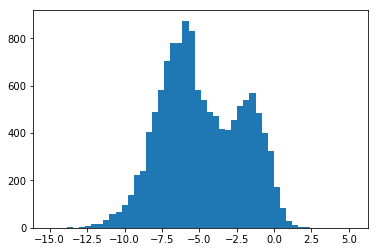

In [44]:
plt.hist(np.log10(-nrtend_tau[nrtend_tau < 0]), bins=50)
#plt.gca().set_yscale("log")

In [90]:
np.min(np.abs(qctend_tau +qrtend_tau))

0.0

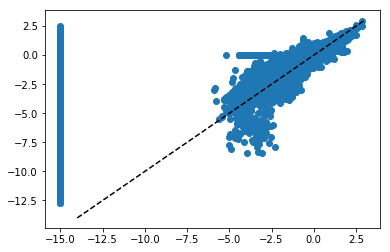

In [16]:
plt.scatter(
log10_transform(nrtend_tau), 
transformed_out_train.loc[:,"nrtend_TAU"])
plt.plot(np.arange(-14, 4),np.arange(-14, 4), 'k--')

In [ ]:
plt.plot(qctend_tau)

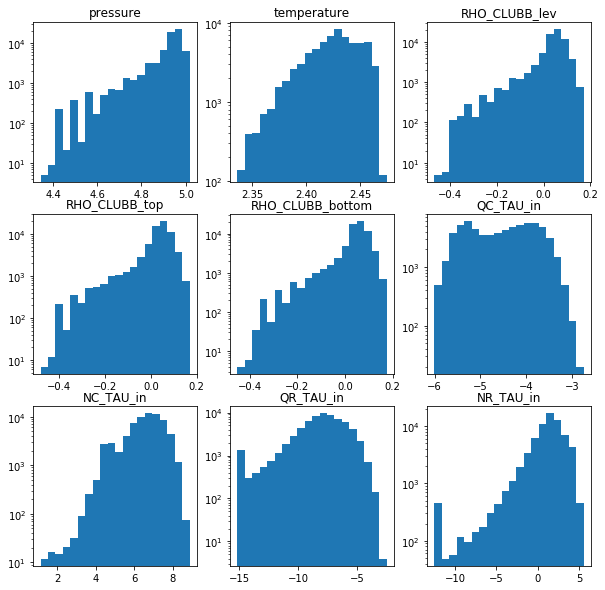

In [242]:
fig, axes = plt.subplots(3,3, figsize=(10, 10))
transformed_input_train = pd.DataFrame(input_scaler.inverse_transform(scaled_input_train), columns=input_cols)
for a, ax in enumerate(axes.ravel()):
    ax.set_yscale("log")
    ax.hist(transformed_input_train[input_cols[a]], bins=20)
    ax.set_title(input_cols[a])

In [24]:
class DenseNeuralNetwork(object):
    """
    A Dense Neural Network Model that can support arbitrary numbers of hidden layers.

    Attributes:
        hidden_layers: Number of hidden layers
        hidden_neurons: Number of neurons in each hidden layer
        inputs: Number of input values
        outputs: Number of output values
        activation: Type of activation function
        output_activation: Activation function applied to the output layer
        optimizer: Name of optimizer or optimizer object.
        loss: Name of loss function or loss object
        use_noise: Whether or not additive Gaussian noise layers are included in the network
        noise_sd: The standard deviation of the Gaussian noise layers
        use_dropout: Whether or not Dropout layers are added to the network
        dropout_alpha: proportion of neurons randomly set to 0.
        batch_size: Number of examples per batch
        epochs: Number of epochs to train
        verbose: Level of detail to provide during training
        model: Keras Model object
    """
    def __init__(self, hidden_layers=1, hidden_neurons=4, activation="relu",
                 output_activation="linear", optimizer="adam", loss="mse", use_noise=False, noise_sd=0.01,
                 lr=0.001, use_dropout=False, dropout_alpha=0.1, batch_size=128, epochs=2,
                 l2_weight=0.01, sgd_momentum=0.9, adam_beta_1=0.9, adam_beta_2=0.999, decay=0, verbose=0,
                 classifier=False):
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        self.activation = activation
        self.output_activation = output_activation
        self.optimizer = optimizer
        self.optimizer_obj = None
        self.sgd_momentum = sgd_momentum
        self.adam_beta_1 = adam_beta_1
        self.adam_beta_2 = adam_beta_2
        self.loss = loss
        self.lr = lr
        self.l2_weight = l2_weight
        self.batch_size = batch_size
        self.use_noise = use_noise
        self.noise_sd = noise_sd
        self.use_dropout = use_dropout
        self.dropout_alpha = dropout_alpha
        self.epochs = epochs
        self.decay = decay
        self.verbose = verbose
        self.classifier = classifier
        self.y_labels = None
        self.model = None
        self.optimizer_obj = None

    def build_neural_network(self, inputs, outputs):
        """
        Create Keras neural network model and compile it.

        Args:
            inputs (int): Number of input predictor variables
            outputs (int): Number of output predictor variables
        """
        nn_input = Input(shape=(inputs,), name="input")
        nn_model = nn_input
        for h in range(self.hidden_layers):
            nn_model = Dense(self.hidden_neurons, activation=self.activation,
                             kernel_regularizer=l2(self.l2_weight), name=f"dense_{h:02d}")(nn_model)
            if self.use_dropout:
                nn_model = Dropout(self.dropout_alpha, name=f"dropout_h_{h:02d}")(nn_model)
            if self.use_noise:
                nn_model = GaussianNoise(self.noise_sd, name=f"ganoise_h_{h:02d}")(nn_model)
        nn_model = Dense(outputs,
                         activation=self.output_activation, name=f"dense_{self.hidden_layers:02d}")(nn_model)
        self.model = Model(nn_input, nn_model)
        if self.optimizer == "adam":
            self.optimizer_obj = Adam(lr=self.lr, beta_1=self.adam_beta_1, beta_2=self.adam_beta_2, decay=self.decay)
        elif self.optimizer == "sgd":
            self.optimizer_obj = SGD(lr=self.lr, momentum=self.sgd_momentum, decay=self.decay)
        self.model.compile(optimizer=self.optimizer, loss=self.loss)

    def fit(self, x, y):
        inputs = x.shape[1]
        if len(y.shape) == 1:
            outputs = 1
        else:
            outputs = y.shape[1]
        if self.classifier:
            outputs = np.unique(y).size
        self.build_neural_network(inputs, outputs)
        if self.classifier:
            self.y_labels = np.unique(y)
            y_class = np.zeros((y.shape[0], self.y_labels.size), dtype=np.int32)
            for l, label in enumerate(self.y_labels):
                y_class[y == label, l] = 1
            self.model.fit(x, y_class, batch_size=self.batch_size, epochs=self.epochs, verbose=self.verbose)
        else:
            self.model.fit(x, y, batch_size=self.batch_size, epochs=self.epochs, verbose=self.verbose)
        return

    def save_fortran_model(self, filename):
        nn_ds = xr.Dataset()
        num_dense = 0
        layer_names = []
        for layer in self.model.layers:
            if "dense" in layer.name:
                layer_names.append(layer.name)
                dense_weights = layer.get_weights()
                nn_ds[layer.name + "_weights"] = ((layer.name + "_in", layer.name + "_out"), dense_weights[0])
                nn_ds[layer.name + "_bias"] = ((layer.name + "_out",), dense_weights[1])
                nn_ds[layer.name + "_weights"].attrs["name"] = layer.name
                nn_ds[layer.name + "_weights"].attrs["activation"] = layer.get_config()["activation"]
                num_dense += 1
        nn_ds["layer_names"] = (("num_layers",), np.array(layer_names))
        nn_ds.attrs["num_layers"] = num_dense
        nn_ds.to_netcdf(filename, encoding={'layer_names':{'dtype': 'S1'}})
        return

    def predict(self, x):
        if self.classifier:
            y_prob = self.model.predict(x, batch_size=self.batch_size)
            y_out = self.y_labels[np.argmax(y_prob, axis=1)].ravel()
        else:
            y_out = self.model.predict(x, batch_size=self.batch_size).ravel()
        return y_out

    def predict_proba(self, x):
        y_prob = self.model.predict(x, batch_size=self.batch_size)
        return y_prob


# Model Training

In [29]:
dnn_qr_class = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30,
                                  loss="categorical_crossentropy",
                                  output_activation="softmax",
                                  activation="relu", epochs=10,
                                  batch_size=2048, verbose=1, lr=0.0001, classifier=True)
dnn_nc_class = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=10,
                                  loss="categorical_crossentropy",
                                  output_activation="softmax",
                                  activation="relu", epochs=10,
                                  batch_size=2048, verbose=1, lr=0.0001, classifier=True)
dnn_qr = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30, 
                         loss="mse", activation="relu", epochs=10, 
                         batch_size=2048, verbose=1, lr=0.0001)
dnn_nc = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30, 
                         loss="mse", activation="relu", epochs=10, 
                         batch_size=2048, verbose=1, l2_weight=0, lr=0.0001)



In [30]:
dnn_qr_class.fit(scaled_input_train, labels_train["qrtend_TAU"])

Epoch 1/10
9728637/9728637 [==============================] - 24s 2us/step - loss: 0.3196
Epoch 2/10
9728637/9728637 [==============================] - 24s 3us/step - loss: 0.2401
Epoch 3/10
9728637/9728637 [==============================] - 23s 2us/step - loss: 0.2290
Epoch 4/10
9728637/9728637 [==============================] - 24s 2us/step - loss: 0.2219
Epoch 5/10
9728637/9728637 [==============================] - 24s 2us/step - loss: 0.2166
Epoch 6/10
9728637/9728637 [==============================] - 24s 3us/step - loss: 0.2126
Epoch 7/10
9728637/9728637 [==============================] - 24s 3us/step - loss: 0.2097
Epoch 8/10
9728637/9728637 [==============================] - 24s 2us/step - loss: 0.2067
Epoch 9/10
9728637/9728637 [==============================] - 24s 2us/step - loss: 0.2043
Epoch 10/10
9728637/9728637 [==============================] - 24s 2us/step - loss: 0.2025


In [31]:
dnn_qr.fit(scaled_input_train.loc[labels_train["qrtend_TAU"] == 1], 
           scaled_out_train.loc[labels_train["qrtend_TAU"] == 1, "qrtend_TAU"].values)

Epoch 1/10
6130813/6130813 [==============================] - 14s 2us/step - loss: 0.2096
Epoch 2/10
6130813/6130813 [==============================] - 15s 2us/step - loss: 0.1067
Epoch 3/10
6130813/6130813 [==============================] - 15s 2us/step - loss: 0.1005
Epoch 4/10
6130813/6130813 [==============================] - 14s 2us/step - loss: 0.0968
Epoch 5/10
6130813/6130813 [==============================] - 14s 2us/step - loss: 0.0942
Epoch 6/10
6130813/6130813 [==============================] - 15s 2us/step - loss: 0.0922
Epoch 7/10
6130813/6130813 [==============================] - 14s 2us/step - loss: 0.0907
Epoch 8/10
6130813/6130813 [==============================] - 14s 2us/step - loss: 0.0894
Epoch 9/10
6130813/6130813 [==============================] - 14s 2us/step - loss: 0.0883
Epoch 10/10
6130813/6130813 [==============================] - 15s 2us/step - loss: 0.0873


In [32]:
dnn_nc.fit(scaled_input_train, scaled_out_train.loc[:, "nctend_TAU"])

Epoch 1/10
9728637/9728637 [==============================] - 22s 2us/step - loss: 0.0451
Epoch 2/10
9728637/9728637 [==============================] - 21s 2us/step - loss: 0.0292
Epoch 3/10
9728637/9728637 [==============================] - 21s 2us/step - loss: 0.0278
Epoch 4/10
9728637/9728637 [==============================] - 22s 2us/step - loss: 0.0271
Epoch 5/10
9728637/9728637 [==============================] - 22s 2us/step - loss: 0.0266
Epoch 6/10
9728637/9728637 [==============================] - 21s 2us/step - loss: 0.0263
Epoch 7/10
9728637/9728637 [==============================] - 22s 2us/step - loss: 0.0259
Epoch 8/10
9728637/9728637 [==============================] - 22s 2us/step - loss: 0.0257
Epoch 9/10
9728637/9728637 [==============================] - 21s 2us/step - loss: 0.0254
Epoch 10/10
9728637/9728637 [==============================] - 22s 2us/step - loss: 0.0253


In [33]:
dnn_nc_class.fit(scaled_input_train, labels_train["nctend_TAU"])

Epoch 1/10
9728637/9728637 [==============================] - 25s 3us/step - loss: 0.1336
Epoch 2/10
9728637/9728637 [==============================] - 24s 2us/step - loss: 0.0792
Epoch 3/10
9728637/9728637 [==============================] - 25s 3us/step - loss: 0.0739
Epoch 4/10
9728637/9728637 [==============================] - 24s 2us/step - loss: 0.0705
Epoch 5/10
9728637/9728637 [==============================] - 25s 3us/step - loss: 0.0684
Epoch 6/10
9728637/9728637 [==============================] - 24s 3us/step - loss: 0.0668
Epoch 7/10
9728637/9728637 [==============================] - 24s 2us/step - loss: 0.0655
Epoch 8/10
9728637/9728637 [==============================] - 24s 2us/step - loss: 0.0645
Epoch 9/10
9728637/9728637 [==============================] - 24s 2us/step - loss: 0.0636
Epoch 10/10
9728637/9728637 [==============================] - 24s 2us/step - loss: 0.0628


In [34]:
save_model(dnn_nc.model, "/glade/p/cisl/aiml/dgagne/cam_run2_models/dnn_nc.h5")
save_model(dnn_qr.model, "/glade/p/cisl/aiml/dgagne/cam_run2_models/dnn_qr.h5")
save_model(dnn_nc_class.model, "/glade/p/cisl/aiml/dgagne/cam_run2_models/dnn_nc_class.h5")
save_model(dnn_qr_class.model, "/glade/p/cisl/aiml/dgagne/cam_run2_models/dnn_qr_class.h5")

In [35]:
dnn_qr_class.save_fortran_model("/glade/p/cisl/aiml/dgagne/cam_run2_models/dnn_qr_class_fortran.nc")
dnn_qr.save_fortran_model("/glade/p/cisl/aiml/dgagne/cam_run2_models/dnn_qr_fortran.nc")
dnn_nc_class.save_fortran_model("/glade/p/cisl/aiml/dgagne/cam_run2_models/dnn_nc_class_fortran.nc")
dnn_nc.save_fortran_model("/glade/p/cisl/aiml/dgagne/cam_run2_models/dnn_nc_fortran.nc")

In [36]:
dnn_nr_class = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30,
                                  loss="categorical_crossentropy",
                                  output_activation="softmax",
                                  activation="relu", epochs=10,
                                  batch_size=2048, verbose=1, lr=0.0001, classifier=True)
dnn_nr_class.fit(scaled_input_train, labels_train["nrtend_TAU"])

Epoch 1/10
9728637/9728637 [==============================] - 26s 3us/step - loss: 0.4722
Epoch 2/10
9728637/9728637 [==============================] - 24s 2us/step - loss: 0.3653
Epoch 3/10
9728637/9728637 [==============================] - 25s 3us/step - loss: 0.3435
Epoch 4/10
9728637/9728637 [==============================] - 25s 3us/step - loss: 0.3300
Epoch 5/10
9728637/9728637 [==============================] - 25s 3us/step - loss: 0.3200
Epoch 6/10
9728637/9728637 [==============================] - 24s 3us/step - loss: 0.3124
Epoch 7/10
9728637/9728637 [==============================] - 24s 2us/step - loss: 0.3068
Epoch 8/10
9728637/9728637 [==============================] - 24s 2us/step - loss: 0.3023
Epoch 9/10
9728637/9728637 [==============================] - 24s 2us/step - loss: 0.2979
Epoch 10/10
9728637/9728637 [==============================] - 25s 3us/step - loss: 0.2940


In [37]:
test_nr_sign = dnn_nr_class.predict(scaled_input_test)

In [38]:

confusion_matrix(labels_test["nrtend_TAU"].values, test_nr_sign)

array([[312181,   6668,  19083],
       [  1815, 432482,  38726],
       [  8006,  34582, 568384]])

In [39]:
confusion_matrix(labels_test["qrtend_TAU"].values, dnn_qr_class.predict(scaled_input_test))

array([[496860,  33756],
       [ 43017, 848294]])

In [40]:
nr_pos_net = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30, 
                         loss="mse", activation="relu", epochs=10, 
                         batch_size=2048, verbose=1, l2_weight=0, lr=0.0001)
nr_neg_net = DenseNeuralNetwork(hidden_layers=6, hidden_neurons=30, 
                         loss="mse", activation="relu", epochs=10, 
                         batch_size=2048, verbose=1, l2_weight=0, lr=0.0001)

In [41]:
pos_sub = labels_train["nrtend_TAU"] == 1
neg_sub = labels_train["nrtend_TAU"] == -1
nr_pos_net.fit(scaled_input_train.loc[pos_sub], scaled_out_train.loc[pos_sub, "nrtend_TAU"])
nr_neg_net.fit(scaled_input_train.loc[neg_sub], scaled_out_train.loc[neg_sub, "nrtend_TAU"])

Epoch 1/10
4217208/4217208 [==============================] - 10s 2us/step - loss: 0.0696
Epoch 2/10
4217208/4217208 [==============================] - 9s 2us/step - loss: 0.0378
Epoch 3/10
4217208/4217208 [==============================] - 10s 2us/step - loss: 0.0347
Epoch 4/10
4217208/4217208 [==============================] - 9s 2us/step - loss: 0.0325
Epoch 5/10
4217208/4217208 [==============================] - 9s 2us/step - loss: 0.0304
Epoch 6/10
4217208/4217208 [==============================] - 9s 2us/step - loss: 0.0277
Epoch 7/10
4217208/4217208 [==============================] - 9s 2us/step - loss: 0.0252
Epoch 8/10
4217208/4217208 [==============================] - 9s 2us/step - loss: 0.0236
Epoch 9/10
4217208/4217208 [==============================] - 9s 2us/step - loss: 0.0226
Epoch 10/10
4217208/4217208 [==============================] - 9s 2us/step - loss: 0.0218
Epoch 1/10
2302705/2302705 [==============================] - 6s 2us/step - loss: 0.0460
Epoch 2/10
2302705

In [95]:
save_model(nr_pos_net.model, "/glade/p/cisl/aiml/dgagne/cam_run2_models/dnn_nr_pos.h5")
save_model(nr_neg_net.model, "/glade/p/cisl/aiml/dgagne/cam_run2_models/dnn_nr_neg.h5")
nr_pos_net.save_fortran_model("/glade/p/cisl/aiml/dgagne/cam_run2_models/dnn_nr_pos_fortran.nc")
nr_pos_net.save_fortran_model("/glade/p/cisl/aiml/dgagne/cam_run2_models/dnn_nr_neg_fortran.nc")


In [42]:
nr_pred_values = np.zeros(scaled_input_test.shape[0])
nr_pred_values[test_nr_sign > 0] = 10 ** output_scalers["nrtend_TAU"][1].inverse_transform(nr_pos_net.predict(scaled_input_test[test_nr_sign > 0]).ravel())
nr_pred_values[test_nr_sign < 0] = -10 ** output_scalers["nrtend_TAU"][-1].inverse_transform(nr_neg_net.predict(scaled_input_test[test_nr_sign < 0]).ravel())

(array([3.1300e+02, 9.5390e+03, 2.3201e+04, 2.3690e+04, 1.2165e+04,
        1.1000e+03, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.7997e+04]),
 array([-14.65470725, -13.18923653, -11.7237658 , -10.25829508,
         -8.79282435,  -7.32735363,  -5.8618829 ,  -4.39641218,
         -2.93094145,  -1.46547073,   0.        ]),
 <a list of 10 Patch objects>)

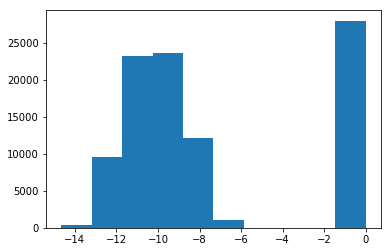

In [31]:
plt.hist(transformed_out_test["qrtend_TAU"])

In [43]:
pred_tendencies = pd.DataFrame(0, index=scaled_out_test.index, columns=output_cols[1:4], dtype=float)
qr_class_preds = dnn_qr_class.predict(scaled_input_test)
pred_tendencies.loc[:, "qrtend_TAU"] = output_scalers["qrtend_TAU"][1].inverse_transform(dnn_qr.predict(scaled_input_test))
pred_tendencies.loc[:, "nctend_TAU"] = output_scalers["nctend_TAU"][1].inverse_transform(dnn_nc.predict(scaled_input_test))
pred_tendencies.loc[:, "nrtend_TAU"] = nr_pred_values


# Partial Dependence Plots

In [79]:
def partial_dependence_1d(x, model, var_index, var_vals):
    """
    Calculate how the mean prediction of an ML model varies if one variable's value is fixed across all input
    examples.

    Args:
        x: array of input variables
        model: scikit-learn style model object
        var_index: column index of the variable being investigated
        var_vals: values of the input variable that are fixed.

    Returns:
        Array of partial dependence values.
    """
    partial_dependence = np.zeros(var_vals.shape)
    x_copy = np.copy(x)
    for v, var_val in enumerate(var_vals):
        x_copy[:, var_index] = var_val
        partial_dependence[v] = model.predict(x_copy).mean()
    return partial_dependence

In [76]:
pd_bins = 20
pd_vals = np.zeros((len(input_cols), pd_bins))
for v, var in enumerate(input_cols):
    print(var, scaled_input_train[var].min(), scaled_input_train[var].max())
    pd_vals[v] = np.linspace( scaled_input_train[var].min(), scaled_input_train[var].max(), pd_bins)

QC_TAU_in -3.96704449750294 1.6963223269822898
QR_TAU_in -2.775906732481771 2.524831792042437
NC_TAU_in -2.7427933724996976 1.9442977890897406
NR_TAU_in -4.894635682043058 2.315526550448108
RHO_CLUBB_lev -6.168230883780295 1.8550678209694687


In [77]:
pd_vals_scaled = input_scaler.transform(log10_transform(pd_vals).T).T


In [82]:
pd_output_qr = np.zeros((len(input_cols), pd_vals.shape[1]))
rand_sub = np.random.permutation(np.arange(np.sum(labels_train["qrtend_TAU"] == 1)))[:50000]
for v, var in enumerate(input_cols):
    print(v, var)
    pd_output_qr[v] = partial_dependence_1d(scaled_input_train.loc[labels_train["qrtend_TAU"] == 1].iloc[rand_sub], dnn_qr, v, 
                                            pd_vals_scaled[v])

0 QC_TAU_in
1 QR_TAU_in
2 NC_TAU_in
3 NR_TAU_in
4 RHO_CLUBB_lev


In [86]:
pd_output_nc = np.zeros((len(input_cols), pd_vals.shape[1]))
for v, var in enumerate(input_cols):
    print(v, var)
    pd_output_nc[v] = partial_dependence_1d(scaled_input_train, dnn_nc, v, pd_vals_scaled[v])

0 QC_TAU_in
1 QR_TAU_in
2 NC_TAU_in
3 NR_TAU_in
4 temperature
5 RHO_CLUBB_lev


In [100]:
pd_output_nr_pos = np.zeros((len(input_cols), pd_vals.shape[1]))
for v, var in enumerate(input_cols):
    print(v, var)
    pd_output_nr_pos[v] = partial_dependence_1d(scaled_input_train.loc[labels_train["nrtend_TAU"] == 1], nr_pos_net, v, pd_vals_scaled[v])

0 QC_TAU_in
1 QR_TAU_in
2 NC_TAU_in
3 NR_TAU_in
4 temperature
5 RHO_CLUBB_lev


In [101]:
pd_output_nr_neg = np.zeros((len(input_cols), pd_vals.shape[1]))
for v, var in enumerate(input_cols):
    print(v, var)
    pd_output_nr_neg[v] = partial_dependence_1d(scaled_input_train.loc[labels_train["nrtend_TAU"] == -1], nr_neg_net, v, pd_vals_scaled[v])

0 QC_TAU_in
1 QR_TAU_in
2 NC_TAU_in
3 NR_TAU_in
4 temperature
5 RHO_CLUBB_lev


In [58]:
pd_grid_tau.shape

(6, 20, 4)

IndexError: index 5 is out of bounds for axis 0 with size 5

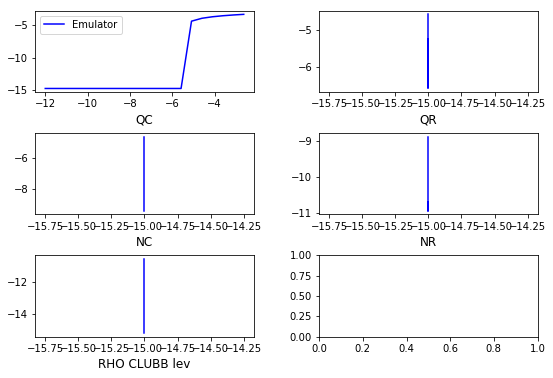

In [94]:
#pd_unscaled = input_scaler.inverse_transform(pd_vals.T)
pd_unscaled_qr = output_scalers["qrtend_TAU"][1].inverse_transform(pd_output_qr)
fig, axes = plt.subplots(3, 2, figsize=(9, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):
    ax.plot(log10_transform(pd_vals[a]), pd_unscaled_qr[a], color='b', label="Emulator")
    #ax.plot(log10_transform(pd_vals[a]), pd_grid_tau[a, :, 2], 'k-', label="TAU")
    ax.set_xlabel(input_cols[a].replace("_TAU_in", "").replace("_", " "), fontsize=12)
    #ax.set_yticks(np.round(np.linspace(np.round(pd_unscaled_qr[a].min(), 1), 
    #                                   np.round(pd_unscaled_qr[a].max(), 2), 4), 2))
    if a == 0:
        ax.legend()
fig.suptitle("Partial Dependence for QR Tendencies", fontsize=16, y=0.94)
plt.savefig("pdp_qr_20190420.png", dpi=200, bbox_inches="tight")

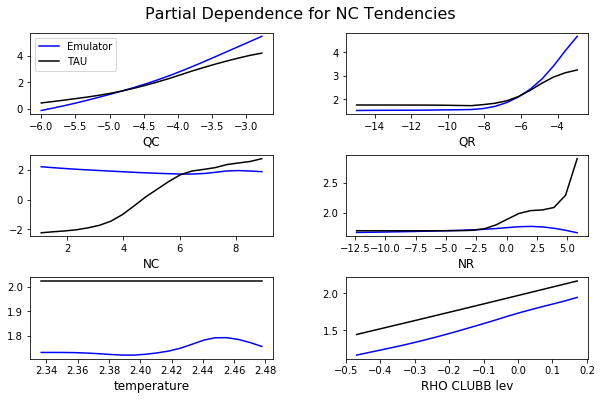

In [112]:
pd_unscaled = input_scaler.inverse_transform(pd_vals.T)
pd_unscaled_nc = output_scalers["nctend_TAU"][1].inverse_transform(pd_output_nc)

fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):
    ax.plot(log10_transform(pd_vals[a]), pd_unscaled_nc[a], 'b-', label="Emulator")
    
    ax.plot(log10_transform(pd_vals[a]), pd_grid_tau[a, :, 1], 'k-', label="TAU")

    ax.set_xlabel(input_cols[a].replace("_TAU_in", "").replace("_", " "), fontsize=12)
    #ax.set_yticks(np.round(np.linspace(np.round(pd_unscaled_nc[a].min(), 1), 
    #                                   np.round(pd_unscaled_nc[a].max(), 2), 4), 2))
    if a == 0:
        ax.legend()
fig.suptitle("Partial Dependence for NC Tendencies", fontsize=16, y=0.94)
plt.savefig("pdp_nc.png", dpi=200, bbox_inches="tight")

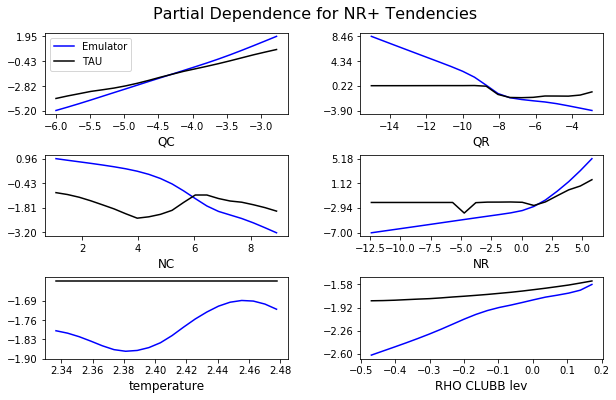

In [109]:
pd_unscaled = input_scaler.inverse_transform(pd_vals.T)
pd_unscaled_nr_pos = output_scalers["nrtend_TAU"][1].inverse_transform(pd_output_nr_pos)
pd_unscaled_nr_neg = output_scalers["nrtend_TAU"][-1].inverse_transform(pd_output_nr_neg)

fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):
        
    ax.plot(log10_transform(pd_vals[a]), pd_unscaled_nr_pos[a], 'b-', label="Emulator")
    ax.plot(log10_transform(pd_vals[a]), pd_grid_tau[a, :, 3], 'k-', label="TAU")

    ax.set_xlabel(input_cols[a].replace("_TAU_in", "").replace("_", " "), fontsize=12)
    ax.set_yticks(np.round(np.linspace(np.round(pd_unscaled_nr_pos[a].min(), 1), 
                                       np.round(pd_unscaled_nr_pos[a].max(), 2), 4), 2))
    if a == 0:
        ax.legend()
fig.suptitle("Partial Dependence for NR+ Tendencies", fontsize=16, y=0.94)
plt.savefig("pdp_nr_pos.png", dpi=200, bbox_inches="tight")

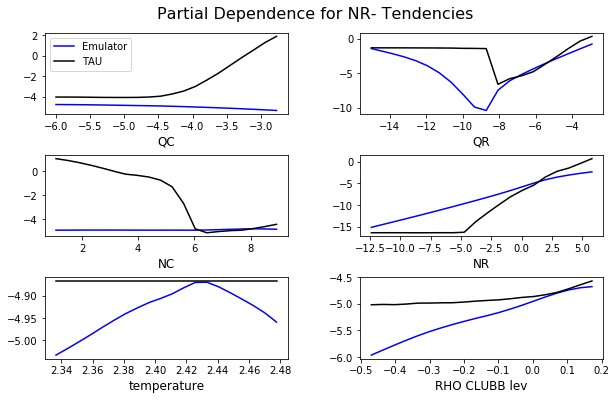

In [115]:
pd_unscaled = input_scaler.inverse_transform(pd_vals.T)
pd_unscaled_nr_pos = output_scalers["nrtend_TAU"][1].inverse_transform(pd_output_nr_pos)
pd_unscaled_nr_neg = output_scalers["nrtend_TAU"][-1].inverse_transform(pd_output_nr_neg)

fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):        
    ax.plot(log10_transform(pd_vals[a]), pd_unscaled_nr_neg[a], 'b-', label="Emulator")
    ax.plot(log10_transform(pd_vals[a]), pd_grid_tau[a, :, 4], 'k-', label="TAU")
    ax.set_xlabel(input_cols[a].replace("_TAU_in", "").replace("_", " "), fontsize=12)
    #ax.set_yticks(np.round(np.linspace(np.round(pd_unscaled_nr_neg[a].min(), 1), 
    #                                   np.round(pd_unscaled_nr_neg[a].max(), 2), 4), 2))
    if a == 0:
        ax.legend()
fig.suptitle("Partial Dependence for NR- Tendencies", fontsize=16, y=0.94)
plt.savefig("pdp_nr_neg.png", dpi=200, bbox_inches="tight")

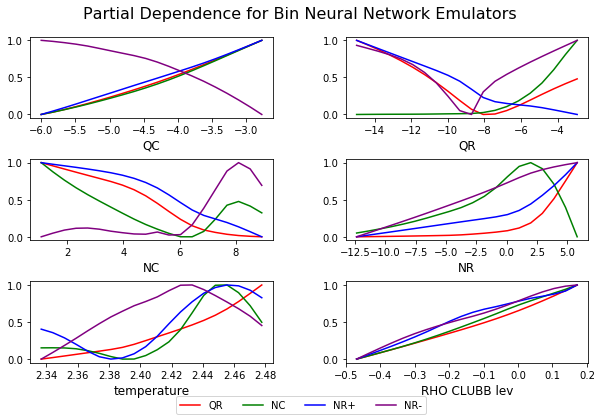

In [119]:
all_pd_out = [pd_output_qr, pd_output_nc, pd_output_nr_pos, pd_output_nr_neg]
pd_names = ["QR", "NC", "NR+", "NR-"]
colors = ['red', 'green', 'blue', 'purple']
fig, axes = plt.subplots(3,2, figsize=(10, 6), sharey=False)
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for a, ax in enumerate(axes.ravel()):
    for o in range(len(all_pd_out)):
        ax.plot(log10_transform(pd_vals[ a]), 
                (all_pd_out[o][a] - all_pd_out[o][a].min()) / (all_pd_out[o][a].max() - all_pd_out[o][a].min()),
                color=colors[o])
    ax.set_xlabel(input_cols[a].replace("_TAU_in", "").replace("_", " "), fontsize=12)
plt.figlegend(pd_names, loc='lower center', ncol=4)
plt.suptitle("Partial Dependence for Bin Neural Network Emulators", y=0.95, fontsize=16)
plt.savefig("pdp_all.png", dpi=200, bbox_inches="tight")

In [175]:
pd_grid_nc = partial_dependence_2d(scaled_input_train, dnn_nc, 5, pd_vals[5], 6, pd_vals[6])

KeyboardInterrupt: 

In [ ]:
plt.contourf(pd_unscaled[:, 6], pd_unscaled[:, 5], pd_grid_nc, np.arange(-3, 3.5, .5), cmap="RdBu_r")
plt.xlabel(input_cols[6])
plt.ylabel(input_cols[5])
plt.colorbar()

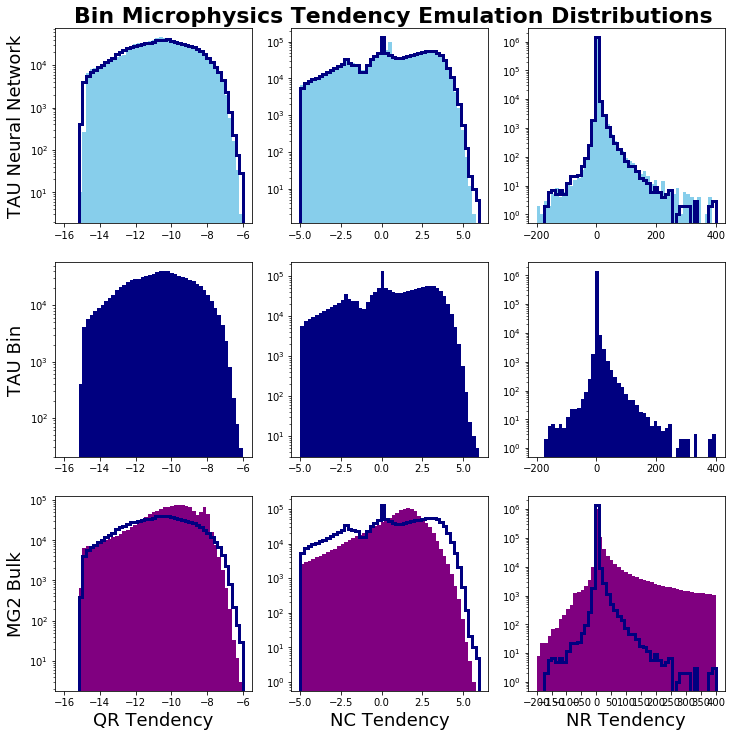

In [68]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
plt.subplots_adjust(0.03, 0.03, 0.96, 0.95, wspace=0.2)
all_bins = [np.linspace(-16, -6, 50), np.linspace(-5,6, 50), np.linspace(-200, 400, 50)]
original_out_test = np.zeros(transformed_out_test["nrtend_TAU"].size)
original_out_test[labels_test["nrtend_TAU"] > 0] = 10 ** transformed_out_test.loc[labels_test["nrtend_TAU"] > 0, 
                                                                                  "nrtend_TAU"]
original_out_test[labels_test["nrtend_TAU"] < 0] = -10 ** transformed_out_test.loc[labels_test["nrtend_TAU"] < 0, 
                                                                                  "nrtend_TAU"]
axes[0, 0].hist(pred_tendencies.loc[labels_test["qrtend_TAU"] == 1, "qrtend_TAU"],
             bins=all_bins[0], color='skyblue')
axes[0, 0].hist(transformed_out_test["qrtend_TAU"], 
            bins=all_bins[0], histtype="step", color="navy", lw=3)
axes[0, 0].set_ylabel("TAU Neural Network", fontsize=18)
axes[0, 0].set_yscale("log")
axes[0, 1].hist(pred_tendencies.loc[:, "nctend_TAU"], 
            bins=all_bins[1], color='skyblue')
axes[0, 1].hist(transformed_out_test["nctend_TAU"], 
            bins=all_bins[1], histtype="step", color="navy", lw=3)
axes[0, 1].set_yscale("log")
#axes[0, 1].set_xlabel("Emulated NC", fontsize=14)
axes[0, 2].hist(pred_tendencies.loc[:, "nrtend_TAU"], 
             bins=all_bins[2], color='skyblue')
axes[0, 2].hist(original_out_test, 
            bins=all_bins[2], histtype="step", color="navy", lw=3)
axes[0, 2].set_yscale("log")
#axes[0, 2].set_xlabel("Emulated NR", fontsize=14)
axes[1, 0].hist(transformed_out_test["qrtend_TAU"],
             bins=all_bins[0], color='navy')
axes[1, 0].set_ylabel("TAU Bin", fontsize=18)
axes[1, 0].set_yscale("log")
#axes[1, 0].set_xlabel("Bin QR", fontsize=14)
axes[1, 1].hist(transformed_out_test["nctend_TAU"], 
            bins=all_bins[1], color='navy')
axes[1, 1].set_yscale("log")
#axes[1, 1].set_xlabel("Bin NC", fontsize=14)

axes[1, 2].hist(original_out_test, 
             bins=all_bins[2], color='navy')
axes[1, 2].set_yscale("log")
#axes[1, 2].set_xlabel("Bin NR", fontsize=14)
axes[2, 0].hist(transformed_out_test["qrtend_MG2"],
               bins=all_bins[0], color='purple')
axes[2, 0].hist(transformed_out_test["qrtend_TAU"], 
            bins=all_bins[0], histtype="step", color="navy", lw=3)
axes[2, 0].set_yscale("log")
axes[2, 0].set_ylabel("MG2 Bulk", fontsize=18)
axes[2, 0].set_xlabel("QR Tendency", fontsize=18)
axes[2, 1].hist(transformed_out_test["nctend_MG2"], 
            bins=all_bins[1], color='purple')
axes[2, 1].hist(transformed_out_test["nctend_TAU"], 
            bins=all_bins[1], histtype="step", color="navy", lw=3)
axes[2, 1].set_yscale("log")
axes[2, 1].set_xlabel("NC Tendency", fontsize=18)
original_out_test_mg = np.zeros(transformed_out_test["nrtend_MG2"].size)
original_out_test_mg[labels_test["nrtend_MG2"] > 0] = 10 ** transformed_out_test.loc[labels_test["nrtend_MG2"] > 0, 
                                                                                  "nrtend_MG2"]
original_out_test_mg[labels_test["nrtend_MG2"] < 0] = -10 ** transformed_out_test.loc[labels_test["nrtend_MG2"] < 0, 
                                                                                  "nrtend_MG2"]
axes[2, 2].hist(original_out_test_mg, 
             bins=all_bins[2], color='purple')
axes[2, 2].hist(original_out_test, 
            bins=all_bins[2], histtype="step", color="navy", lw=3)
axes[2, 2].set_yscale("log")
axes[2, 2].set_xticks(np.arange(-200, 450, 50))
axes[2, 2].set_xlabel("NR Tendency", fontsize=18)
#axes[0, 0].set_ylabel("Frequency", fontsize=14)
#axes[1, 0].set_ylabel("Frequency", fontsize=14)
#axes[2, 0].set_ylabel("Frequency", fontsize=14)
fig.suptitle("Bin Microphysics Tendency Emulation Distributions", y=0.98, fontsize=22, fontweight="bold")
plt.savefig("nn_bin_hist.png", dpi=200, bbox_inches="tight")
plt.savefig("nn_bin_hist.pdf", dpi=200, bbox_inches="tight")

In [192]:
transformed_out_test.loc[transformed_out_test["qrtend_TAU"] < 0, "qrtend_TAU"]

0       -11.758728
3       -10.194901
4        -9.364924
9       -13.402578
13      -10.557598
14      -10.289907
16      -11.657069
17       -9.239288
18      -11.521441
19       -9.431602
20       -9.261008
22       -9.468618
23       -9.423866
26       -9.049459
28       -8.015106
29      -10.582174
30       -9.777781
31       -9.862971
34      -10.963488
35      -10.082544
37      -11.568765
38      -11.309095
39       -9.847729
40      -11.847333
42      -10.144269
43      -10.780347
45       -8.915291
48      -10.692613
49      -10.577247
51       -8.435481
           ...    
97976    -8.933398
97977    -8.872843
97978   -10.252928
97979    -9.869181
97980    -9.822349
97981    -8.684698
97982   -10.227599
97983   -11.365665
97984    -9.880169
97985    -9.555189
97986   -11.378923
97987   -10.096209
97988   -10.491423
97989   -11.941214
97990   -10.785126
97991   -13.017644
97992   -13.018031
97993   -13.017515
97994   -13.020953
97995   -13.021616
97996   -13.021560
97997   -11.

In [47]:
rmses = np.zeros(3)
rmses[0] = np.sqrt(mean_squared_error(transformed_out_test.loc[transformed_out_test["qrtend_TAU"] < 0, "qrtend_TAU"], 
                                      pred_tendencies.loc[transformed_out_test["qrtend_TAU"] < 0, "qrtend_TAU"]))
rmses[1] = np.sqrt(mean_squared_error(transformed_out_test["nctend_TAU"], 
                                      pred_tendencies.loc[:, "nctend_TAU"]))
original_out_test = np.zeros(transformed_out_test["nrtend_TAU"].size)
original_out_test[labels_test["nrtend_TAU"] > 0] = 10 ** transformed_out_test.loc[labels_test["nrtend_TAU"] > 0, 
                                                                                  "nrtend_TAU"]
original_out_test[labels_test["nrtend_TAU"] < 0] = -10 ** transformed_out_test.loc[labels_test["nrtend_TAU"] < 0, 
                                                                                  "nrtend_TAU"]
rmses[2] = np.sqrt(mean_squared_error(original_out_test, 
                                      pred_tendencies.loc[:, "nrtend_TAU"]))
r2s = np.zeros(3)
r2s[0] = np.corrcoef(transformed_out_test.loc[transformed_out_test["qrtend_TAU"] < 0, "qrtend_TAU"], 
                  pred_tendencies.loc[transformed_out_test["qrtend_TAU"] < 0, "qrtend_TAU"])[0, 1] ** 2
r2s[1] = np.corrcoef(transformed_out_test["nctend_TAU"], 
                  pred_tendencies.loc[:, "nctend_TAU"])[0, 1] ** 2
r2s[2] = np.corrcoef(original_out_test, 
                  pred_tendencies.loc[:, "nrtend_TAU"])[0, 1] ** 2

/glade/work/dgagne/ncar_pylib_dl/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


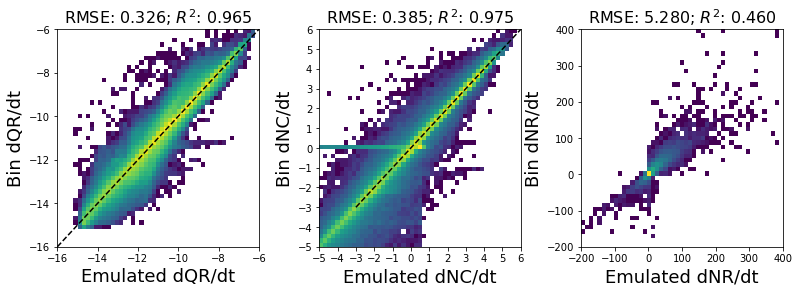

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
plt.subplots_adjust(wspace=0.3)
axes[0].hist2d(pred_tendencies["qrtend_TAU"], 
               transformed_out_test["qrtend_TAU"],
               cmin=1, bins=all_bins[0], norm=LogNorm())
axes[0].set_xlabel("Emulated dQR/dt", fontsize=18)
axes[0].set_ylabel("Bin dQR/dt", fontsize=18)
axes[1].set_xticks(np.arange(-16, 7))
axes[1].set_yticks(np.arange(-16, 7))
axes[0].plot(np.arange(-16, 7),np.arange(-16, 7), 'k--')
axes[0].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses[0], r2s[0]), fontsize=16)
axes[1].hist2d(pred_tendencies["nctend_TAU"], 
               transformed_out_test["nctend_TAU"],
               cmin=1, bins=all_bins[1], norm=LogNorm())
axes[1].set_xlabel("Emulated dNC/dt", fontsize=18)
axes[1].set_ylabel("Bin dNC/dt", fontsize=18)
axes[1].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses[1], r2s[1]), fontsize=16)
axes[1].set_xticks(np.arange(-5, 7))
axes[1].set_yticks(np.arange(-5, 7))
axes[1].plot(np.arange(-3, 7),np.arange(-3, 7), 'k--')
axes[2].hist2d(pred_tendencies["nrtend_TAU"], 
               original_out_test,
               cmin=1, bins=all_bins[2], norm=LogNorm())
axes[2].set_xlabel("Emulated dNR/dt", fontsize=18)
axes[2].set_ylabel("Bin dNR/dt", fontsize=18)
axes[2].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses[2], r2s[2]), fontsize=16)
#axes[2].set_xticks(np.arange(-400, 500, 100))
#axes[2].set_yticks(np.arange(-400, 500, 100))
#axes[2].plot(np.arange(-400, 500, 100),np.arange(-400, 500, 100), 'k--')
plt.savefig("nn_bin_hist2d.png", dpi=300, bbox_inches="tight")

In [49]:
def inverse_nr(nr_labels, nr_vals):
    inverse_vals = np.zeros(nr_vals.size)
    inverse_vals[nr_labels > 0] = 10 ** nr_vals[nr_labels > 0]
    inverse_vals[nr_labels < 0] = -10 ** nr_vals[nr_labels < 0]
    return inverse_vals

In [51]:
rmses_bulk = np.zeros(3)
rmses_bulk[0] = np.sqrt(mean_squared_error(transformed_out_test["qrtend_TAU"], 
                                           transformed_out_test["qrtend_MG2"]))
rmses_bulk[1] = np.sqrt(mean_squared_error(transformed_out_test["nctend_TAU"], 
                                           transformed_out_test["nctend_MG2"]))
rmses_bulk[2] = np.sqrt(mean_squared_error(inverse_nr(labels_test["nrtend_TAU"], transformed_out_test["nrtend_TAU"]), 
                                           inverse_nr(labels_test["nrtend_MG2"], transformed_out_test["nrtend_MG2"])))
r2s_bulk = np.zeros(3)
r2s_bulk[0] = np.corrcoef(transformed_out_test["qrtend_TAU"], 
                       transformed_out_test["qrtend_MG2"])[0, 1] ** 2
r2s_bulk[1] = np.corrcoef(transformed_out_test["nctend_TAU"], 
                       transformed_out_test["nctend_MG2"])[0, 1] ** 2
r2s_bulk[2] = np.corrcoef(inverse_nr(labels_test["nrtend_TAU"], transformed_out_test["nrtend_TAU"]), 
                       inverse_nr(labels_test["nrtend_MG2"], transformed_out_test["nrtend_MG2"]))[0, 1] ** 2

/glade/work/dgagne/ncar_pylib_dl/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


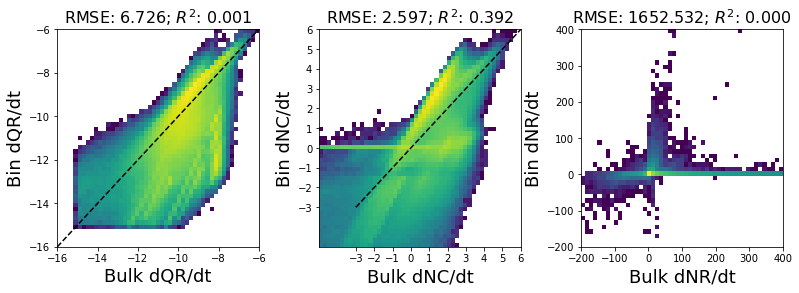

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
plt.subplots_adjust(wspace=0.3)
axes[0].hist2d(transformed_out_test["qrtend_MG2"], 
               transformed_out_test["qrtend_TAU"],
               cmin=1, bins=all_bins[0], norm=LogNorm())
axes[0].set_xlabel("Bulk dQR/dt", fontsize=18)
axes[0].set_ylabel("Bin dQR/dt", fontsize=18)
axes[1].set_xticks(np.arange(-16, 7))
axes[1].set_yticks(np.arange(-16, 7))
axes[0].plot(np.arange(-16, 7),np.arange(-16, 7), 'k--')
axes[0].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses_bulk[0], r2s_bulk[0]), fontsize=16)
axes[1].hist2d(transformed_out_test["nctend_MG2"], 
               transformed_out_test["nctend_TAU"],
               cmin=1, bins=all_bins[1], norm=LogNorm())
axes[1].set_xlabel("Bulk dNC/dt", fontsize=18)
axes[1].set_ylabel("Bin dNC/dt", fontsize=18)
axes[1].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses_bulk[1], r2s_bulk[1]), fontsize=16)
axes[1].set_xticks(np.arange(-3, 7))
axes[1].set_yticks(np.arange(-3, 7))
axes[1].plot(np.arange(-3, 7),np.arange(-3, 7), 'k--')
axes[2].hist2d(inverse_nr(labels_test["nrtend_MG2"], transformed_out_test["nrtend_MG2"]), 
               inverse_nr(labels_test["nrtend_TAU"], transformed_out_test["nrtend_TAU"]),
               cmin=1, bins=all_bins[2], norm=LogNorm())
axes[2].set_xlabel("Bulk dNR/dt", fontsize=18)
axes[2].set_ylabel("Bin dNR/dt", fontsize=18)
axes[2].set_title("RMSE: {0:0.3f}; $R^2$: {1:0.3f}".format(rmses_bulk[2], r2s_bulk[2]), fontsize=16)
#axes[2].set_xticks(np.arange(-400, 500, 100))
#axes[2].set_yticks(np.arange(-400, 500, 100))
#axes[2].plot(np.arange(-400, 500, 100),np.arange(-400, 500, 100), 'k--')
plt.savefig("nn_bulk_hist2d.png", dpi=300, bbox_inches="tight")